In [ ]:
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
import plotly.plotly as py

%matplotlib inline

In [4]:
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Загрузим данные. Они содержат интервал с пропущенными значениями. Выделим отдельно временной ряд ts_no_outs без большого пропуска. По умолчанию будем работать с ним.

In [8]:
ts = pd.read_csv('dataset1_with_outliers_data.csv')
ts.index = pd.to_datetime(ts['ds'])
ts.sort_index(inplace=True)

ts_test = ts[datetime(2015,1,1):]

ts_full = ts[:datetime(2015,1,1)]
ts_no_outs = ts_full[datetime(2012, 1,1):]

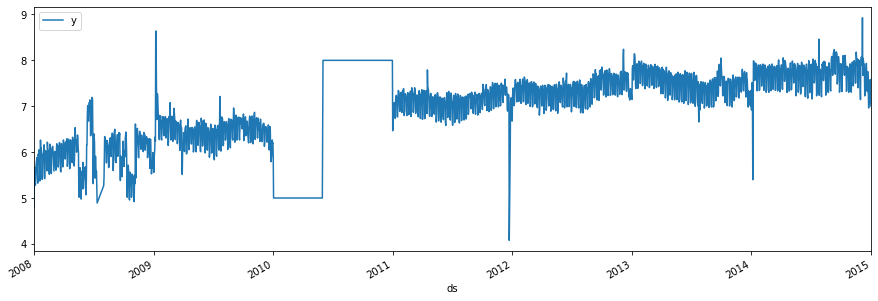

In [10]:
ts_full.plot(figsize=(15,5))

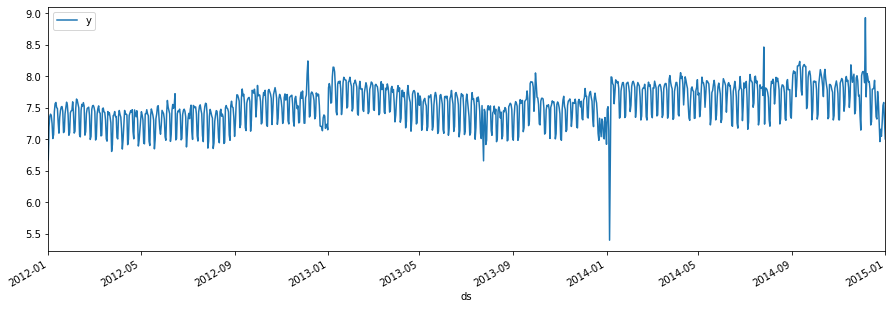

In [12]:
ts_no_outs.plot(figsize=(15,5))

Часть 0.

In [14]:
ts_no_outs

,ds,y
ds,,
2012-01-01,2012-01-01,6.675823
2012-01-02,2012-01-02,7.194437
2012-01-03,2012-01-03,7.362645
2012-01-04,2012-01-04,7.396949
2012-01-05,2012-01-05,7.374629
2012-01-06,2012-01-06,7.247081
2012-01-07,2012-01-07,7.010312
2012-01-08,2012-01-08,7.073270
2012-01-09,2012-01-09,7.437795


Часть 1. Проверка ряда на стационарность

Проверьте ряд на стационарность (например, с помощью критерия Дики-Фуллера). Попробуйте привести его к стационарному виду (с помощью преобразования Бокса-Кокса, дифференцирования etc.)

После получения стационарного ряда напишите функцию прямой transform и обратной inv_transform трансформации временного ряда (т.е. исходный ряд -> стационарный ряд и стационарный ряд -> исходный ряд).

In [20]:
def transform(df):
    plt.figure(figsize=(15,10))
    sm.tsa.seasonal_decompose(df['y'], freq = 30).plot()
    print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['y'])[1])
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(ts_no_outs['y'])[1])

 Критерий Дики-Фуллера: p=0.074175


Часть 2. Обнаружение выбросов 

С помощью экспоненциального сглаживания найдите выбросы в данных (и попробуйте их сгладить). Для этого подберите оптимальные значения параметров alpha, beta и std_window. Функция для детекции аномалий и сглаживания приведена ниже. Обратите внимание, мы работаем лишь с ts_train, тестовый датасет ts_test "находится в будущем" и нам недоступен.



In [22]:
def exponential_smoothing_anomaly_filter(series, alpha, beta=2.5, std_window=10):
    """
    Anomaly filter based on simple exponential smoothing.

    Parameters
    ----------
    series : pandas.Series
        Time series to smooth.
    alpha : float in range [0., 1.]
        Smoothing parameter. The smaller is `alpha`, the smoother are result series.
    beta: float
        Multiplier for rolling standard deviation. If the deviation from smoothed time series in some point is bigger
        than `beta`*rolling_std, that point is marked as anomaly.
    std_window : int
        Rolling std window width.

    Returns
    -------
    _ : pandas.Series
        Smoothed time series.
    _ : pandas.Series
        Series containing anomalies (both time and value).
    """


    result = [series[0]] # first value is same as series
    sx = series.rolling(std_window).std()
    anomalies_index = []
    anomalies_values = []
#     print(len(series), len(sx))
    for n in range(1, len(series)):
        if n > std_window:
            if abs(series[n] - result[n-1]) > sx[n]*beta:
                result.append(result[n-1])
                anomalies_index.append(series.index[n])
                anomalies_values.append(series[n])
                continue
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(index=series.index, data=result), pd.Series(index=anomalies_index, data=anomalies_values)

In [24]:
ts_no_outs['ty'], ts_no_outs['ay'] = exponential_smoothing_anomaly_filter(ts_no_outs['y'], 0.35, 1.5, 29)
dk = sm.tsa.stattools.adfuller(ts_no_outs['ty'])[1]
dk

0.01918734883565836

 Критерий Дики-Фуллера: p=0.019187


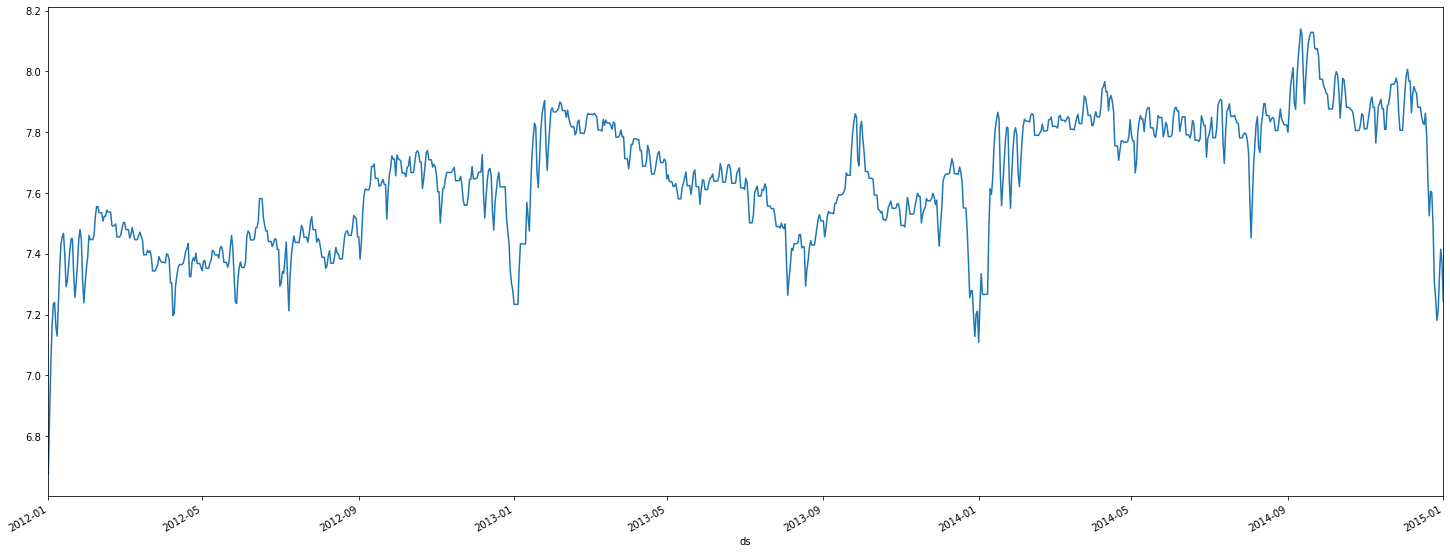

In [26]:
plt.figure(figsize=(25,10))
ts_no_outs['ty'].plot()
print(" Критерий Дики-Фуллера: p=%f" % dk)

Часть 3. Построение прогнозов с помощью библиотеки Facebook Prophet

Построение прогноза

Сделайте предсказание на год вперед на основании ts_no_outs и ts_full. Для этого вам пригодится функция make_future_dataframe().

In [32]:
ts_no_outs

,ds,y,ty,ay
ds,,,,
2012-01-01,2012-01-01,6.675823,6.675823,NaN
2012-01-02,2012-01-02,7.194437,6.857338,NaN
2012-01-03,2012-01-03,7.362645,7.034196,NaN
2012-01-04,2012-01-04,7.396949,7.161159,NaN
2012-01-05,2012-01-05,7.374629,7.235874,NaN
2012-01-06,2012-01-06,7.247081,7.239796,NaN
2012-01-07,2012-01-07,7.010312,7.159477,NaN
2012-01-08,2012-01-08,7.073270,7.129304,NaN
2012-01-09,2012-01-09,7.437795,7.237276,NaN


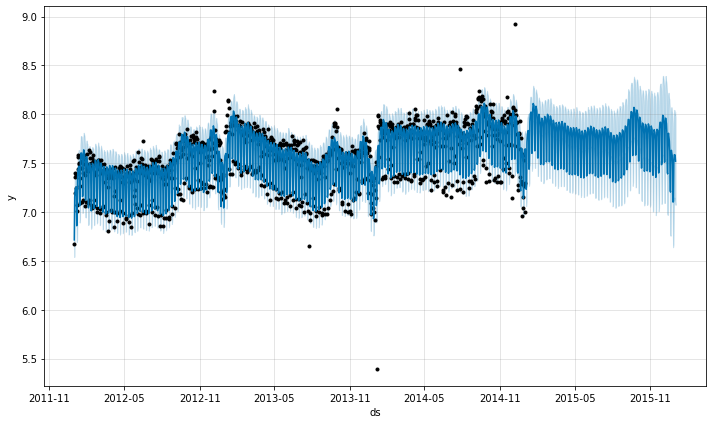

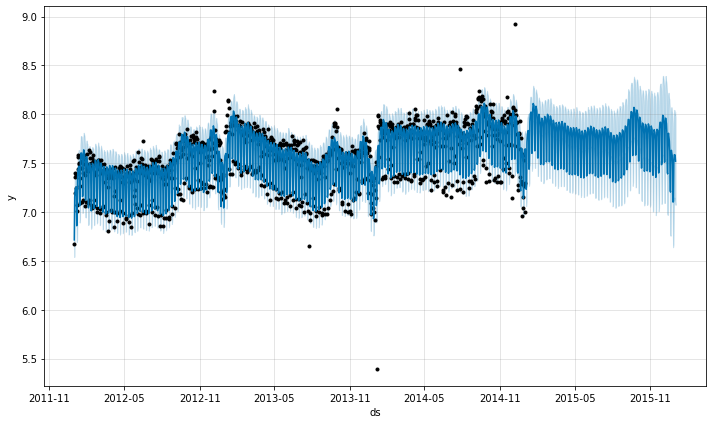

In [38]:
fmodel = Prophet()
fmodel.fit(ts_no_outs)
future = fmodel.make_future_dataframe(periods=365)
forecast = fmodel.predict(future)

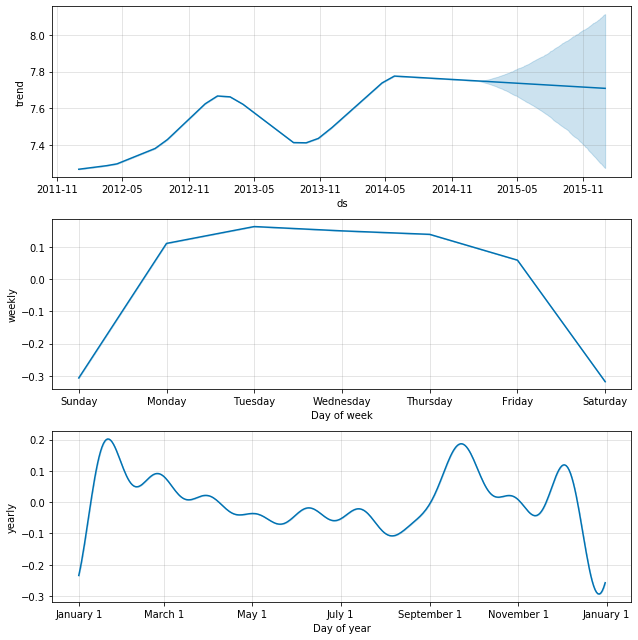

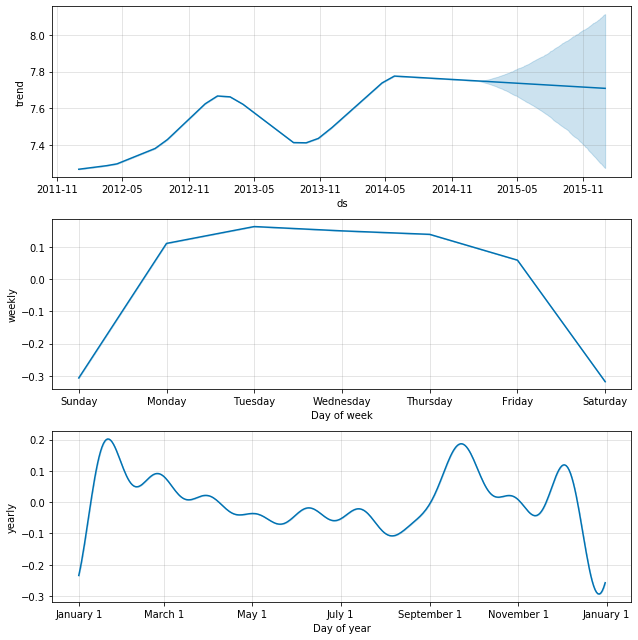

In [42]:
fmodel.plot_components(forecast)

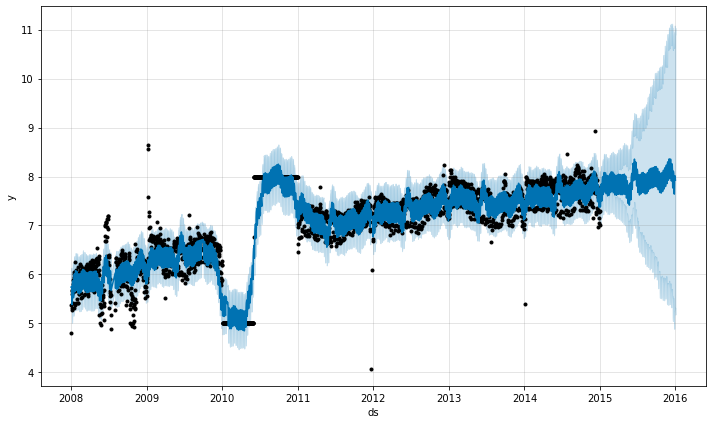

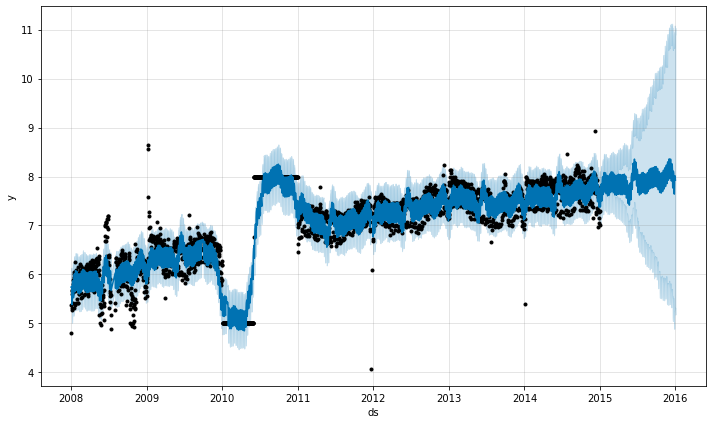

In [44]:
fmodel1 = Prophet()
fmodel1.fit(ts_full)
future1 = fmodel1.make_future_dataframe(periods=365)
forecast1 = fmodel1.predict(future1)
fmodel1.plot(forecast1)

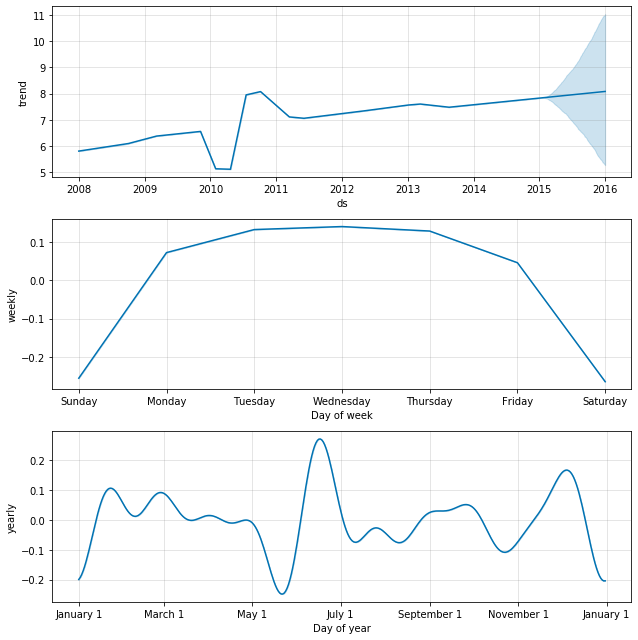

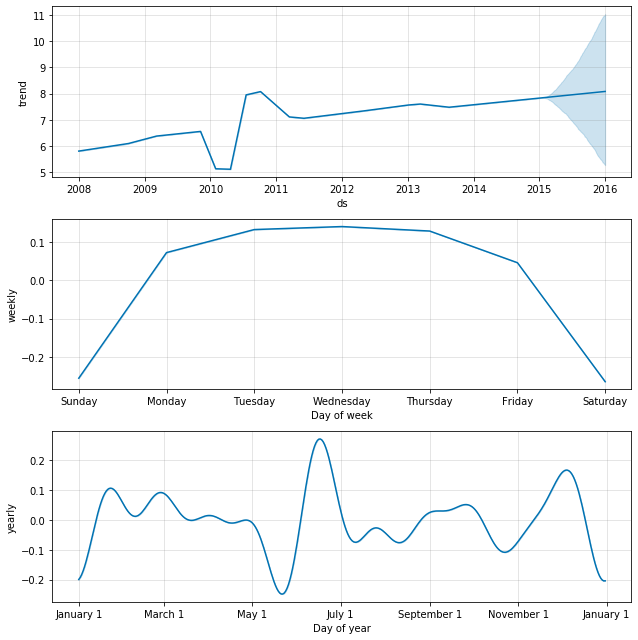

In [46]:
fmodel1.plot_components(forecast1)

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score (т.е. сравните прогноз с реальным поведением временного ряда). Для этого может быть полезна функция make_comparison_dataframe (приведенная в статье).

In [50]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))
cmp_df  = make_comparison_dataframe(ts_no_outs, forecast)
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 9.171853243470927
MAE 0.642394229030864


Tакже визуально оцените дисперсию прогноза в случае обучения на ts_no_outs и на ts_full.

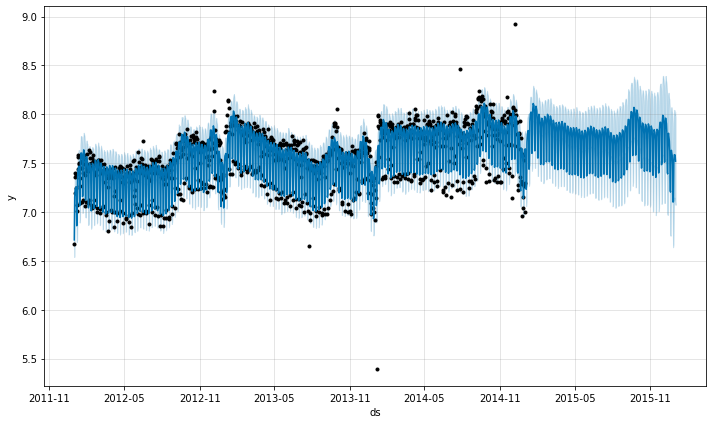

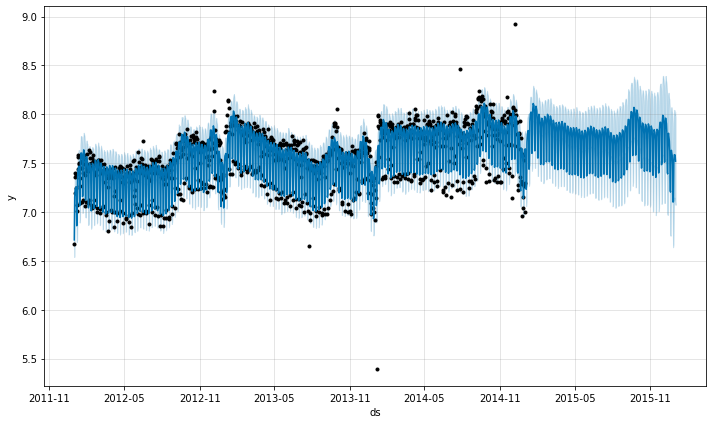

In [52]:
fmodel.plot(forecast)

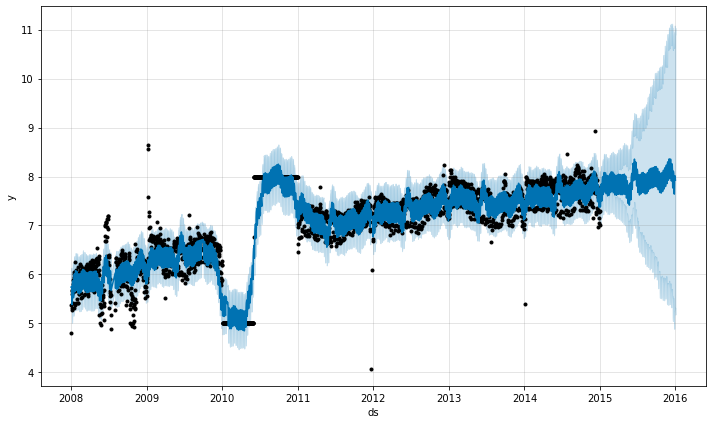

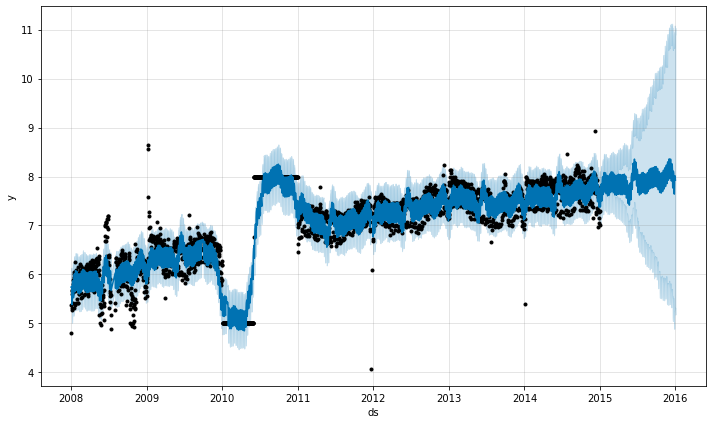

In [54]:
fmodel1.plot(forecast1)

Автоматическая работа с пропущенными значениями (25%)
На самом деле, библиотека Facebook Prophet умеет работать с пропущенными значениями. Создайте копию ts_copy ряда ts_full и замените в ней значения с 2010-01-01 по 2011-01-01 на None.



In [56]:
ts_copy = ts_full.copy()

In [58]:
ts_copy['y'][datetime(2010,1,1):datetime(2011,1,1)] = None
ts_copy[datetime(2010,1,1):datetime(2011,1,1)]

,ds,y
ds,,
2010-01-01,2010-01-01,NaN
2010-01-02,2010-01-02,NaN
2010-01-03,2010-01-03,NaN
2010-01-04,2010-01-04,NaN
2010-01-05,2010-01-05,NaN
2010-01-06,2010-01-06,NaN
2010-01-07,2010-01-07,NaN
2010-01-08,2010-01-08,NaN
2010-01-09,2010-01-09,NaN


Снова постройте прогноз на год вперед, но теперь на основании ts_copy.

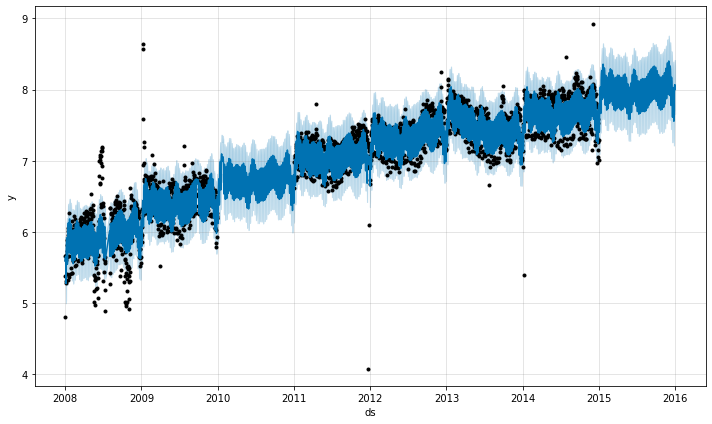

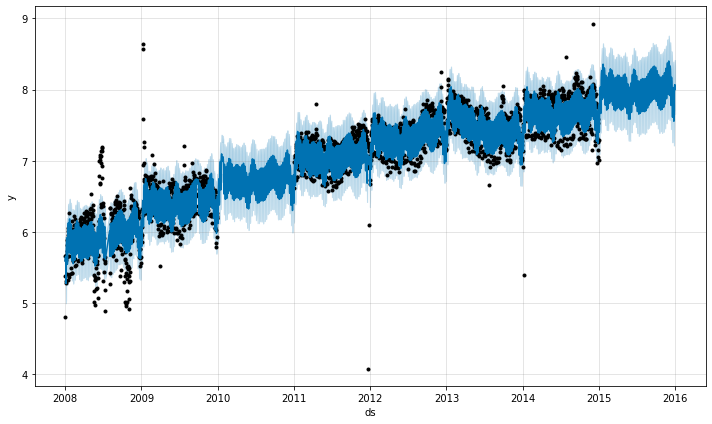

In [62]:
fmodel2 = Prophet()
fmodel2.fit(ts_copy)
future2 = fmodel2.make_future_dataframe(periods=365)
forecast2 = fmodel2.predict(future2)
fmodel2.plot(forecast2)

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score. Стал ли прогноз лучше? Что стало с дисперсие прогноза?

In [64]:
cmp_df  = make_comparison_dataframe(ts_copy, forecast2)
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 11.157817127554539
MAE 0.7814906258367333


MSE было  9.171853243470927, а стало 11.15781712755453, алгоритм хуже предсказывает

Добавление информации о выходных днях.
Добавьте информацию о выходных днях (суббота и воскресенье)

In [85]:
saturdays  = pd.DataFrame({
  'holiday': 'saturday',
  'ds': ts.loc[ts.index.weekday == 5].ds
})


sundays  = pd.DataFrame({
  'holiday': 'sunday',
  'ds': ts.loc[ts.index.weekday == 6].ds
})

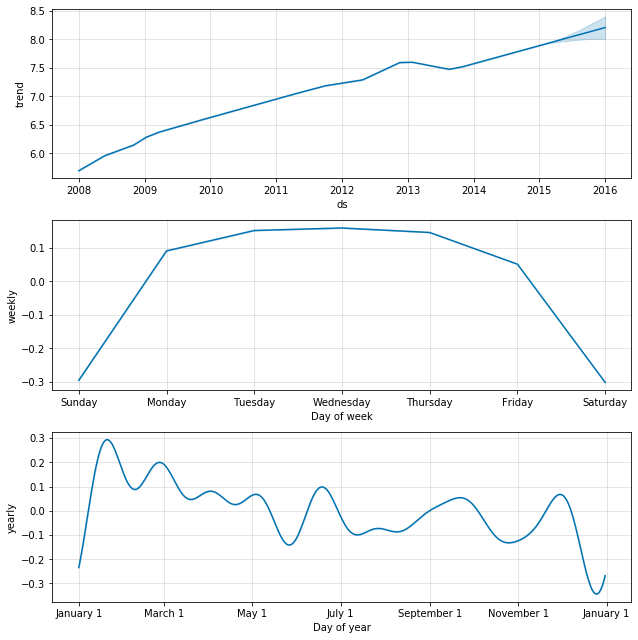

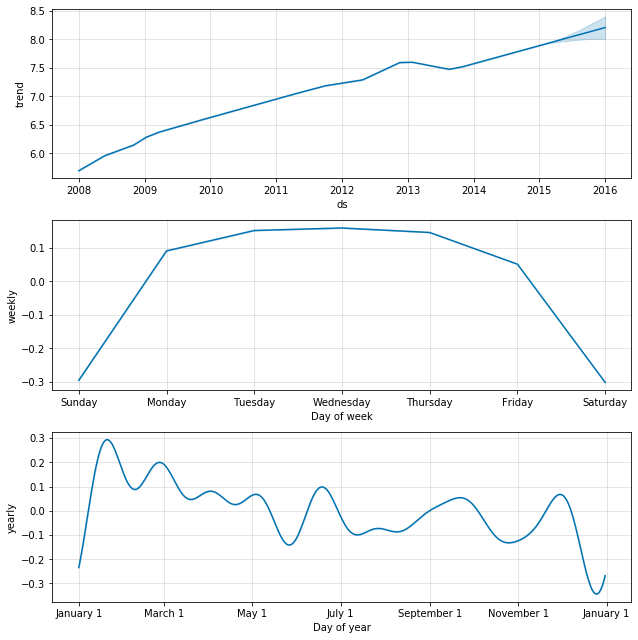

In [80]:
fmodel2.plot_components(forecast2)

Постройте прогноз на год вперед c учетом выходных дней на основании ts_copy

In [82]:
ts_copy = ts_full.copy()
ts_copy['y'][datetime(2011,1,1):datetime(2012,1,1)] = None
ts_copy[datetime(2011,1,1):datetime(2012,1,1)]

,ds,y
ds,,
2011-01-01,2011-01-01,NaN
2011-01-02,2011-01-02,NaN
2011-01-03,2011-01-03,NaN
2011-01-04,2011-01-04,NaN
2011-01-05,2011-01-05,NaN
2011-01-06,2011-01-06,NaN
2011-01-07,2011-01-07,NaN
2011-01-08,2011-01-08,NaN
2011-01-09,2011-01-09,NaN


In [73]:
fmodel4 = Prophet()
fmodel4.fit(ts_copy)
future4 = fmodel2.make_future_dataframe(periods=365)
forecast4 = fmodel4.predict(future4)

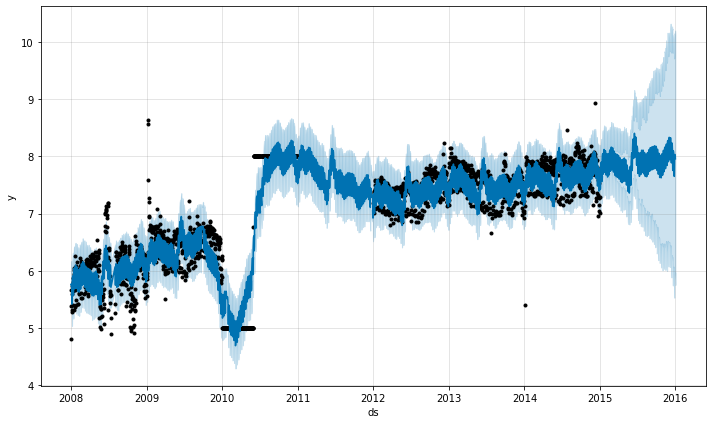

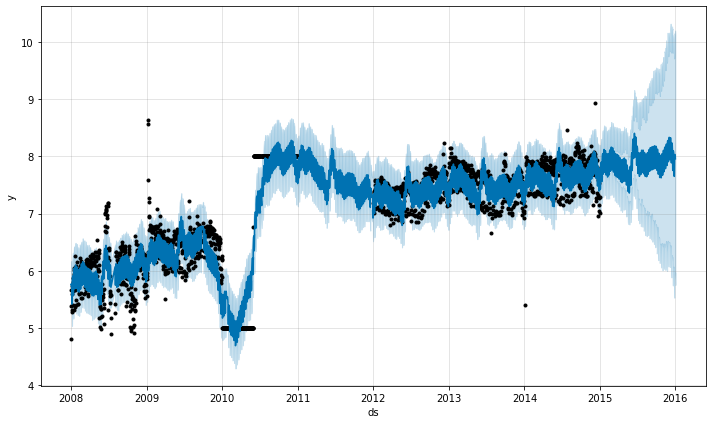

In [75]:
fmodel4.plot(forecast4)

In [77]:
cmp_df  = make_comparison_dataframe(ts_copy, forecast4)

Оцените качество прогноза с помощью MSE, MAE и $r^2$-score. Стал ли прогноз лучше? Что стало с дисперсие прогноза?

In [79]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MSE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['p']))))
print('MAE {}'.format(np.mean(abs(cmp_df[datetime(2015,1,1):]['e']))))

MSE 11.171140658512488
MAE 0.7824238024991264
